<a href="https://colab.research.google.com/github/TatKhachatryan/Time-Series-Analysis-Project/blob/main/ts_analysis_food_prices_arm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab
!pip install -U kaleido
import condacolab
condacolab.install()
!conda install -c plotly python-kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
✨🍰✨ Everything looks OK!
Solving environment: - \ | / - \ | / - \ | / - \ | / - done

# All requested packages already installed.



In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
# data source: https://data.humdata.org/dataset/wfp-food-prices-for-armenia

data = pd.read_csv('/content/drive/MyDrive/Food_Prices_Armenia/wfp_food_prices_arm.csv')
data

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+flag,#item+price+type,#currency,#value,#value+usd
1,1996-01-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (diesel),L,actual,Retail,AMD,100.0,0.2487
2,1996-01-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (petrol-gasoline),L,actual,Retail,AMD,130.0,0.3233
3,1996-02-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (diesel),L,actual,Retail,AMD,100.0,0.2484
4,1996-02-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (petrol-gasoline),L,actual,Retail,AMD,120.0,0.2981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35392,2023-08-15,Yerevan,Yerevan,Yerevan,40.181111,44.513611,vegetables and fruits,Cabbage,KG,forecast,Retail,AMD,0.0,0.0
35393,2023-08-15,Yerevan,Yerevan,Yerevan,40.181111,44.513611,vegetables and fruits,Carrots,KG,forecast,Retail,AMD,0.0,0.0
35394,2023-08-15,Yerevan,Yerevan,Yerevan,40.181111,44.513611,vegetables and fruits,Cucumbers (greenhouse),KG,forecast,Retail,AMD,0.0,0.0
35395,2023-08-15,Yerevan,Yerevan,Yerevan,40.181111,44.513611,vegetables and fruits,Onions,KG,forecast,Retail,AMD,0.0,0.0


So the columns' descriptions are:

*   **date** - baldate
*   **admin1** - province (region)
*   **admin2** - city/village/region names
*   **market** - local market name
*   **latitude** - geographic measure
*   **longitude** - geographic measure
*   **category** - item type
*   **commodity** - item name
*   **unit** - item unit
*   **priceflag** - item price flag
*   **pricetype** - item price type
*   **currency** - item currency
*   **price** - item price value
*   **usdprice** - item price value in usd




In [4]:
# dropping the first unnecessary row
data = data.iloc[1:]

# changing the column names to more friendly names
data.columns = ['Date', 'Province', 'Area', 'Market', 'Latitude', 'Longitude',
       'Item Category', 'Item Name', 'Unit', 'Priceflag', 'Pricetype', 'Currency',
       'Price', 'USD_price']

data = data[data['Priceflag']!='forecast']
data = data.reset_index(drop=True)

# Data Processing
## Missing Values

In [5]:
missing_values = data.isna().sum()
missing_values[missing_values>0]

Province     306
Area         306
Latitude     306
Longitude    306
dtype: int64

In [6]:
print("Market Names:", data[data['Province'].isnull()]['Market'].unique())
print("Item Names:", data[data['Province'].isnull()]['Item Name'].unique())
print()

data[data['Province'].isnull()].head()

Market Names: ['National Average']
Item Names: ['Fuel (diesel)' 'Fuel (petrol-gasoline)' 'Exchange rate']



,Date,Province,Area,Market,Latitude,Longitude,Item Category,Item Name,Unit,Priceflag,Pricetype,Currency,Price,USD_price
0,1996-01-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (diesel),L,actual,Retail,AMD,100.0,0.2487
1,1996-01-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (petrol-gasoline),L,actual,Retail,AMD,130.0,0.3233
2,1996-02-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (diesel),L,actual,Retail,AMD,100.0,0.2484
3,1996-02-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (petrol-gasoline),L,actual,Retail,AMD,120.0,0.2981
4,1996-03-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (diesel),L,actual,Retail,AMD,110.0,0.2726


So, the reason that we have 324 missing values is caused by Market Name called **"National Average"**, which is logical,
as "National Average" can not have a geographical latitude/longtitude or Province and Area.

In [7]:
# data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27550 entries, 0 to 27549
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           27550 non-null  object
 1   Province       27244 non-null  object
 2   Area           27244 non-null  object
 3   Market         27550 non-null  object
 4   Latitude       27244 non-null  object
 5   Longitude      27244 non-null  object
 6   Item Category  27550 non-null  object
 7   Item Name      27550 non-null  object
 8   Unit           27550 non-null  object
 9   Priceflag      27550 non-null  object
 10  Pricetype      27550 non-null  object
 11  Currency       27550 non-null  object
 12  Price          27550 non-null  object
 13  USD_price      27550 non-null  object
dtypes: object(14)
memory usage: 2.9+ MB


In [8]:
# convert object types to their corresponding types
data['Date'] = pd.to_datetime(data['Date'])
data['Price'] = data['Price'].astype(float)
data['USD_price'] = data['USD_price'].astype(float)

In [9]:
# new features from existing ones for EDA
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month_name()
data['Quarter'] = pd.PeriodIndex(data['Date'], freq='Q')

now = datetime.datetime.now()
data['Year_Range'] = now.year-data['Year']

data = data[data['Year']!=2023]
data['Date_Month'] = pd.to_datetime(data['Date']).dt.to_period('M')
data

,Date,Province,Area,Market,Latitude,Longitude,Item Category,Item Name,Unit,Priceflag,Pricetype,Currency,Price,USD_price,Year,Month,Quarter,Year_Range,Date_Month
0,1996-01-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (diesel),L,actual,Retail,AMD,100.0,0.2487,1996,January,1996Q1,27,1996-01
1,1996-01-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (petrol-gasoline),L,actual,Retail,AMD,130.0,0.3233,1996,January,1996Q1,27,1996-01
2,1996-02-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (diesel),L,actual,Retail,AMD,100.0,0.2484,1996,February,1996Q1,27,1996-02
3,1996-02-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (petrol-gasoline),L,actual,Retail,AMD,120.0,0.2981,1996,February,1996Q1,27,1996-02
4,1996-03-15,NaN,NaN,National Average,NaN,NaN,non-food,Fuel (diesel),L,actual,Retail,AMD,110.0,0.2726,1996,March,1996Q1,27,1996-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26848,2022-12-15,Yerevan,Yerevan,Yerevan,40.181111,44.513611,vegetables and fruits,Cabbage,KG,actual,Retail,AMD,146.2,0.3708,2022,December,2022Q4,1,2022-12
26849,2022-12-15,Yerevan,Yerevan,Yerevan,40.181111,44.513611,vegetables and fruits,Carrots,KG,actual,Retail,AMD,342.6,0.8690,2022,December,2022Q4,1,2022-12
26850,2022-12-15,Yerevan,Yerevan,Yerevan,40.181111,44.513611,vegetables and fruits,Cucumbers (greenhouse),KG,actual,Retail,AMD,1025.4,2.6009,2022,December,2022Q4,1,2022-12
26851,2022-12-15,Yerevan,Yerevan,Yerevan,40.181111,44.513611,vegetables and fruits,Onions,KG,actual,Retail,AMD,306.6,0.7777,2022,December,2022Q4,1,2022-12


# Exploratory Data Analysis

In [10]:
# defining the visualization's color scheme
colorScheme = ['#001219','#005F73','#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#BB3E03','#AE2012','#9B2226']

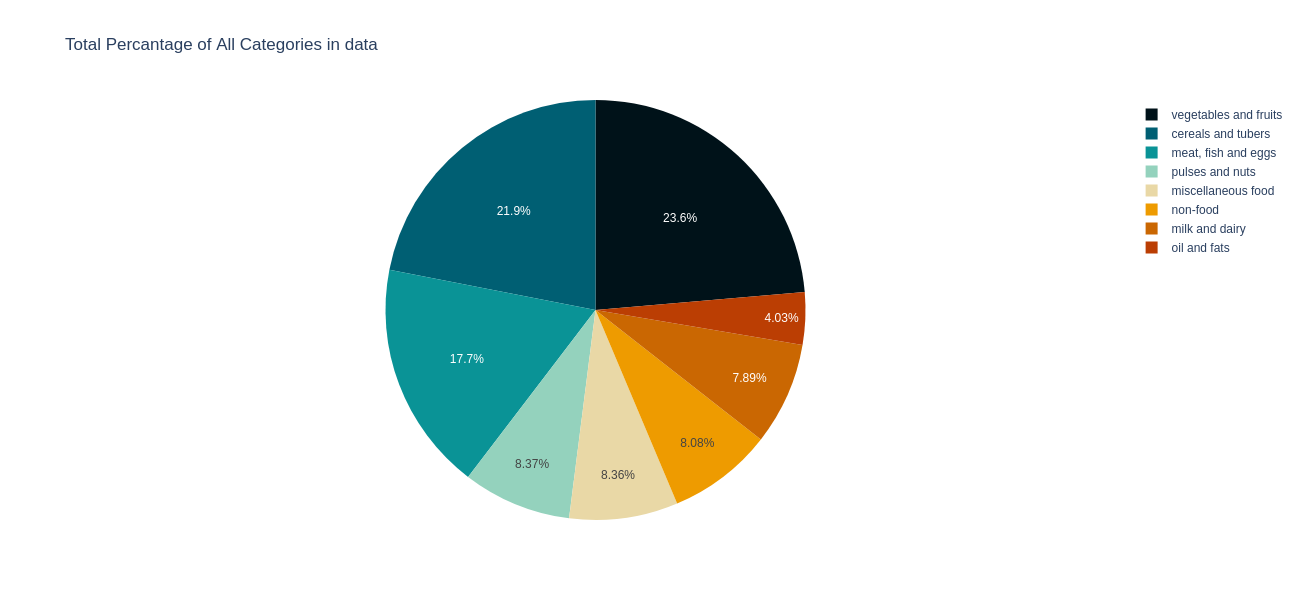

In [17]:
itemCategories = data['Item Category'].value_counts()

pieFig = px.pie(itemCategories,
                names=itemCategories.index,
                values=itemCategories.values,
                title='Total Percantage of All Categories in data',
                color_discrete_sequence=colorScheme)
pieFig.update_layout(autosize=False,
                  width=1300,
                  height=600)
pieFig.show(renderer='png')

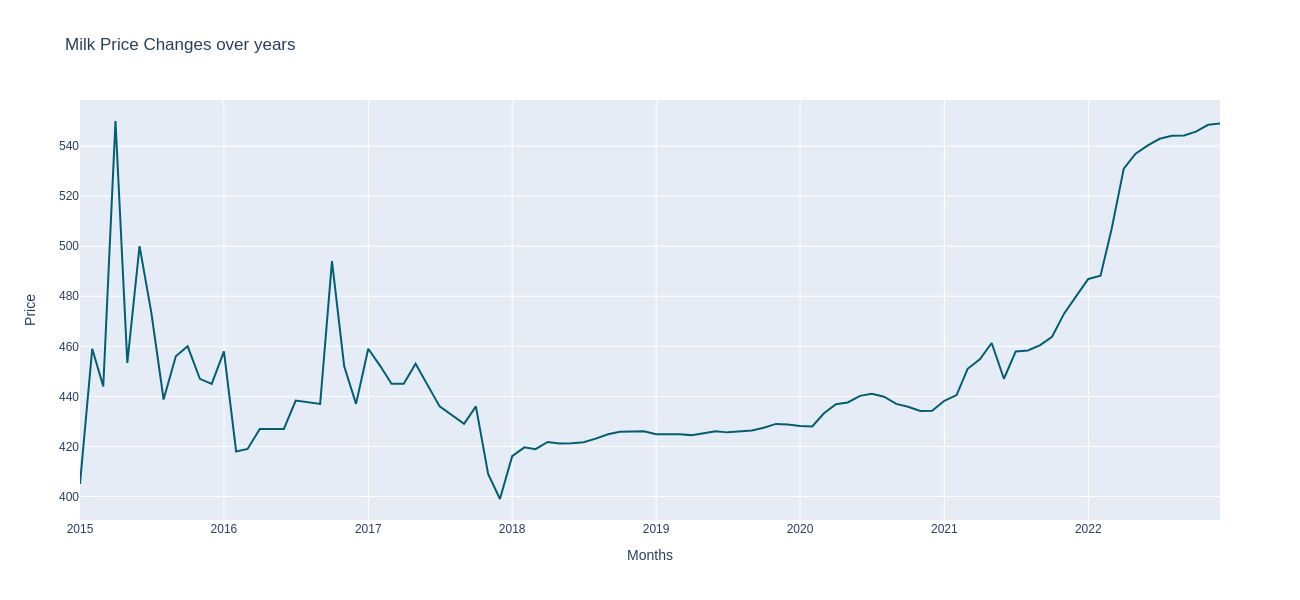

In [16]:
milkDairy = data[data['Item Category']=='milk and dairy']
milkData = milkDairy[(milkDairy['Item Name']=='Milk')&(milkDairy['Year']>2014)]
milkData = milkData.groupby('Date_Month')['Price'].mean().to_frame()
milkData = milkData.reset_index()


fig = go.Figure(data=go.Scatter(x=milkData['Date_Month'].astype(dtype=str), 
                        y=milkData['Price'],
                        marker_color='#005F73', text="counts"))
fig.update_layout(autosize=False,
                  width=1300,
                  height=600,
                  title = 'Milk Price Changes over years',
                  xaxis={"title":"Months"},
                  yaxis= {"title":"Price"},
                  showlegend=False)
fig.show(renderer='png')